In [18]:
import numpy as np
import glob, os
import torch as pt
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

def applySHlight(normal_images, sh_coeff):
  N = normal_images
  sh = pt.stack(
    [
      N[0] * 0.0 + 1.0,
      N[0],
      N[1],
      N[2],
      N[0] * N[1],
      N[0] * N[2],
      N[1] * N[2],
      N[0] ** 2 - N[1] ** 2,
      3 * (N[2] ** 2) - 1,
    ],
    0,
  )  # [9, h, w]
  pi = np.pi
  constant_factor = pt.tensor(
    [
      1 / np.sqrt(4 * pi),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
    ]
  ).float()
  sh = sh * constant_factor[:, None, None]

  shading = pt.sum(
    sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
  )  # [9, 3, h, w]

  return shading

def applySHlightXYZ(xyz, sh):
  out = applySHlight(xyz, sh)
  # out /= pt.max(out)
  # out *= 0.7
  return pt.clip(out, 0, 1)

def genSurfaceNormals(n):
  x = pt.linspace(-1, 1, n)
  y = pt.linspace(1, -1, n)
  y, x = pt.meshgrid(y, x)

  z = (1 - x ** 2 - y ** 2)
  z[z < 0] = 0
  z = pt.sqrt(z)
  return pt.stack([x, y, z], 0)

def drawSphere(sh, img_size=256):
  n = img_size
  xyz = genSurfaceNormals(n)
  out = applySHlightXYZ(xyz, sh)
  out[:, xyz[2] == 0] = 0
  return out

def drawMap(sh, img_size=256):
    n = img_size
    lr = pt.linspace(0, 2 * np.pi, 2 * n)
    ud = pt.linspace(0, np.pi, n)
    ud, lr = pt.meshgrid(ud, lr)

    # we want to make the sphere unwrap at the center of this map,
    # so the left-most column is the furthest-away point on the sphere
    # lr going counter-clockwise = increasing in value.
    # ud starting from 0 (top) to pi (bottom).
    # Lattitude = azimuth = deg from one of xz axis
    # Longtitude = elevation = deg from y-axis
    # In standard unitsphere orientation;
    # z = up (so set y = pt(cos(ud))) ref. https://www.learningaboutelectronics.com/Articles/Spherical-to-cartesian-rectangular-coordinate-converter-calculator.php
    x = -pt.sin(ud) * pt.sin(lr)  # Negative to ensure correct left-right orientation
    y = pt.cos(ud)                # No negative sign needed for up-down orientation
    z = -pt.sin(ud) * pt.cos(lr)  # Negative to ensure correct front-back orientation

    lm = n // 2
    rm = n + (n // 2)

    out = applySHlightXYZ(pt.stack([x, y, z], 0), sh)
    out_centered = out[:, :, lm:rm].clone()
    out_clean = out.clone()
    out[:, :, lm] = pt.tensor((1, 0, 0))[:, None]
    out[:, :, rm] = pt.tensor((1, 0, 0))[:, None]
    return out, out_centered, out_clean


def drawSH(sh_np, img_size=256):
    sh = pt.tensor(sh_np).view(9, 3) 
    ball = drawSphere(sh, img_size)
    map, map_centered, map_clean = drawMap(sh, img_size)
    combined = pt.cat([ball, map], 2)
    # save_image(combined, output)
    # save_image(map_centered, output.replace(".png", "_centered.png"))
    return ball, map, map_centered, map_clean, combined

file = glob.glob('./shcoeffs/*.npy')
os.makedirs('./shimgs', exist_ok=True)
for f in file:
    sh = np.load(f)
    sh = sh.T
    # Swap axis on 2nd dimension
    # sh[:, [0, 1]] = sh[:, [1, 0]]
    # sh[:, [0, 2]] = sh[:, [2, 0]]
    # sh[:, [1, 2]] = sh[:, [2, 1]]
    
    ball, map, map_centered, map_clean, combined = drawSH(sh, img_size=256)
    for j in zip([ball, map, map_centered, map_clean, combined], ['ball', 'map', 'map_centered', 'map_clean', 'combined']):
        torchvision.utils.save_image(j[0], f"./shimgs/{os.path.basename(f).replace('.npy', '')}_{j[1]}.png")
        # save_image(j[0], f"{out_path}/{j[1]}/.png")
    
    # out = drawSphere(pt.tensor(sh).float(), 256).numpy()
    # print(out.shape, out.min(), out.max())
    # Image.fromarray((out * 255).astype(np.uint8).transpose(1, 2, 0)).save(f.replace('shcoeffs', 'shimgs').replace('.npy', '.png'))

(514, 1028, 3) 0.0 8.021825397917855
(514, 1028, 3) 0.0 0.952326


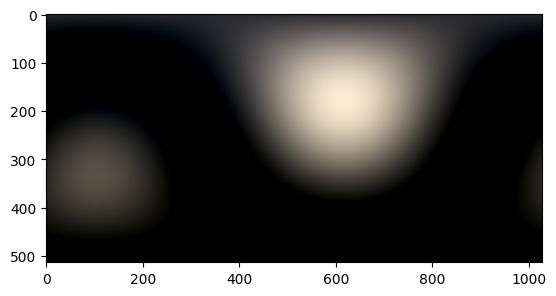

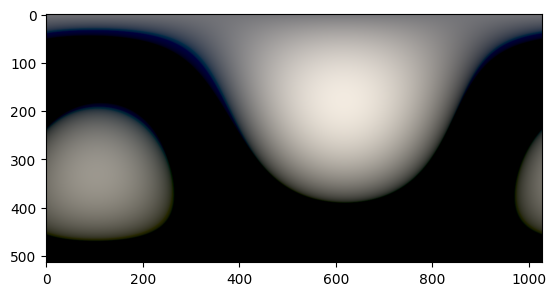

In [3]:
from envmap import EnvironmentMap
from tools3d import spharm
import tonemapper


e = EnvironmentMap('/home/mint/Dev/DiFaReli/difareli-faster/experiment_scripts/TPAMI/envs_to_bg_sh/envmap/exr/meadow_2_8k.exr', 'latlong')
max_l = 2
sh = spharm.SphericalHarmonic(e, max_l=max_l)
import numpy as np
# print(len(sh.coeffs))
# print(sh.coeffs[0].shape)
reconstruction = sh.reconstruct(height=256, max_l=max_l)

tonemap = tonemapper.TonemapHDR()#2.4, 99, 0.9)
image, _, _ = tonemap(reconstruction)

print(reconstruction.shape, reconstruction.min(), reconstruction.max())
print(image.shape, image.min(), image.max())
import matplotlib.pyplot as plt
plt.imshow(((reconstruction/reconstruction.max()) * 255).astype(np.uint8))
plt.show()
plt.imshow(image)
plt.show()

In [10]:
# import hdrtools.tonemapping
# _tonemapper(reconstruction)

import subprocess
_availToneMappers = subprocess.check_output(["/bin/bash -c \"compgen -c pfstmo\""],
                                            stderr=subprocess.STDOUT,
                                            shell=True).decode('ascii').strip().split("\n")



CalledProcessError: Command '['/bin/bash -c "compgen -c pfstmo"']' returned non-zero exit status 1.